In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import scipy.integrate
import scipy.linalg
import math

In [139]:
np.seterr(all='raise')

df = pd.read_csv("../sampledata/shuttle.csv")
sampledata = df["0"]
sampledata = np.float64(sampledata)

# df = pd.read_csv("~/mb-azure/java_impl/data/uci_retail_cleaned.csv")
# sampledata = retail["x"]
# sampledata = np.float64(sampledata)

# Scale to between -1 and 1
# x_min = np.min(sampledata)
# x_max = np.max(sampledata)
# sampledata = (sampledata - x_min)
# sampledata = sampledata / np.max(sampledata)
# sampledata = (sampledata-.5)*2

def moments(data, n):
    return [
        sum([x**i for x in data]) for i in range(2*n + 1)
    ]

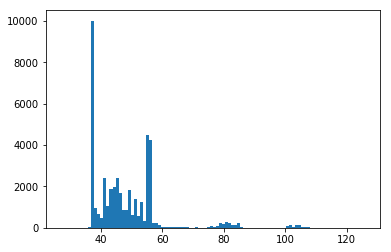

In [140]:
plt.hist(sampledata, bins=100)
plt.show()

In [141]:
print(sampledata.max())
print(sampledata.min())

126.0
27.0


In [142]:
estimate = 45.
n = 5  # use up to the 2n-th moment

# Hungarian Bounds

In [143]:
# http://www.sciencedirect.com/science/article/pii/S0895717705004863#fd16
def hankel_det(m):
    n = int((len(m) - 1) / 2)
    matrix = []
    for r in range(n+1):
        matrix.append(m[r:r+n+1])
    matrix = np.asarray(matrix)
    return np.linalg.det(matrix)

# Moments on data shifted so point of interest is 0
def max_mass_at_zero(normalized_moments):
    n = int((len(normalized_moments) - 1) / 2)
    numerator_matrix = []
    for r in range(n+1):
        numerator_matrix.append(normalized_moments[r:r+n+1])
    numerator_matrix = np.asarray(numerator_matrix)
    denominator_matrix = []
    for r in range(2, n+2):
        denominator_matrix.append(normalized_moments[r:r+n])
    denominator_matrix = np.asarray(denominator_matrix)
    p = np.linalg.det(numerator_matrix) / np.linalg.det(denominator_matrix)
    return p

# Moments on data shifted so point of interest is 0
# Question: should first moment also be subtracted by p?
def gen_orthogonal_P(normalized_moments):
    n = int((len(normalized_moments) - 1) / 2)
    # Scale not actually necessary
#     scale = 1. / math.sqrt(hankel_det(normalized_moments[:-2]) * hankel_det(normalized_moments))
    scale = 1.
    
    matrix = []
    for r in range(n):
        matrix.append(normalized_moments[r:r+n+1])
    matrix = np.asarray(matrix)
        
    coefs = []
    sign = 1 if n % 2 == 0 else -1
    for i in range(n+1):
        minor = np.delete(matrix, i, axis=1)
        coefs.append(scale * sign * (-1)**i * np.linalg.det(minor))
    
    def P(x):
        return sum([coefs[i] * x**i for i in range(n+1)])
    return P, coefs

In [144]:
def bounds(data, C, n):
    # shift data so C is 0
    data = np.float64(data - C)
    m = moments(data, n)
    m /= m[0]
    p = max_mass_at_zero(m)
    print("Bound size: ", p)
    m[0] -= p
    P, coefs = gen_orthogonal_P(m)
    xs = np.roots(coefs[::-1])
    A = []
    for i in range(n):
        A.append([x**i for x in xs])
    A = np.asarray(A)
    weights = np.linalg.solve(A, m[:n])
    L = 0
    for x, w in zip(xs, weights):
        if x < 0:
            L += w
    U = L + p
    print("Positions ", xs)
    print("Weights ", weights)
    print("Quantile of estimate is between: ", L, U)
    return xs, weights, p

In [145]:
positions, weights, p = bounds(sampledata, estimate, n)

sdata = np.sort(sampledata)
print("Actual quantile: ", np.searchsorted(sdata, estimate) / len(sdata))

Bound size:  0.334080763111
Positions  [ 76.03550259  58.83042749  36.03970306  10.27032056  -7.70168767]
Weights  [ 0.00032456  0.01592261  0.04119362  0.30547727  0.30300118]
Quantile of estimate is between:  0.303001179025 0.637081942137
Actual quantile:  0.447149425287


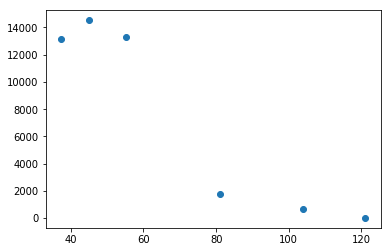

In [146]:
positions_to_plot = np.append(positions + estimate, estimate)
weights_to_plot = np.append(weights, p) * len(sampledata)
to_plot = sorted(zip(positions_to_plot, weights_to_plot))
plt.scatter([p[0] for p in to_plot], [p[1] for p in to_plot])
plt.show()

# cvxpy Bounds

In [147]:
import cvxpy as cvx

def cvx_bounds(data, C, n, resolution=1000):
    m = moments(data, n)
    k = 2*n
    minval = np.min(data)
    maxval = np.max(data)
    
    locs = np.concatenate([
        np.linspace(minval, maxval, resolution),
    ])
    locs = np.sort(locs)
    loc_moments = []
    for i in range(k+1):
        loc_moments.append(
            locs**i
        )
    loc_moments = np.array(loc_moments)
    idx = np.searchsorted(locs, C)
    count = m[0]

    Xs = cvx.Variable(len(locs))

    constraints = [
        Xs >= 0,
        Xs[0] >= 1,
        Xs[-1] >= 1,
        loc_moments * Xs == m
    ]
    l_prob = cvx.Problem(
        cvx.Minimize(cvx.sum_entries(Xs[:idx+1])),
        constraints,
    )
    lb = l_prob.solve(solver=cvx.GLPK)
    lb_dist = Xs.value
    
    u_prob = cvx.Problem(
        cvx.Maximize(cvx.sum_entries(Xs[:idx+1])),
        constraints
    )
    ub = u_prob.solve(solver=cvx.GLPK)
    ub_dist = Xs.value
    return lb/count, ub/count, lb_dist, ub_dist, locs

In [148]:
lb, ub, lb_dist, ub_dist, locs = cvx_bounds(sampledata, estimate, n)
print(lb, ub)

0.306960314105 0.637413418802


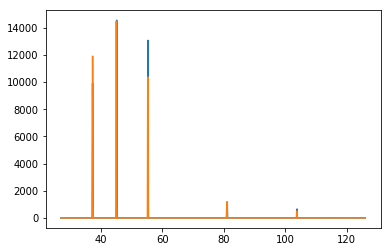

In [149]:
plt.plot(locs, lb_dist)
plt.plot(locs, ub_dist)
plt.show()

In [150]:
xy = zip(locs, [x[0] for x in lb_dist.tolist()])
xy = [pair for pair in xy if pair[1] > 0]
print(xy)

[(27.0, 1.0), (37.306306306306304, 9904.50745048306), (37.405405405405403, 3447.2662130678464), (45.135135135135137, 14547.04917741344), (55.342342342342342, 13065.10721396146), (55.441441441441441, 42.726591929488606), (81.00900900900902, 621.6035639511196), (81.108108108108098, 1163.8802765124665), (103.70270270270271, 35.5257603601959), (103.8018018018018, 655.6014155806887), (119.85585585585585, 10.371641998896543), (119.95495495495496, 4.360694741331709), (126.0, 1.0)]


In [151]:
def xy_moments(xy, n):
    moments = []
    for i in range(2*n+1):
        moment = 0
        for pair in xy:
            moment += pair[0]**i * pair[1]
        moments.append(moment)
    return moments
        
xy_m = xy_moments(xy, n)
print(xy_m == moments(sampledata, n))
print(xy_m)
print(moments(sampledata, n))

False
[43499.999999999993, 2098863.9999999995, 107800016.0, 6005831427.9999981, 369924186368.0, 25475420299083.996, 1954803892405975.8, 1.6430830896853085e+17, 1.4790926986227182e+19, 1.3971091486866444e+21, 1.3638448459556249e+23]
[43500.0, 2098864.0, 107800016.0, 6005831428.0, 369924186368.0, 25475420299084.0, 1954803892405976.0, 1.6430830896853082e+17, 1.4790926986227182e+19, 1.3971091486866444e+21, 1.3638448459556252e+23]
